# Finding equivalent circuits for Blue Rat data
This uses a hybrid optimization routine -- which is much more thorough otpimization to find a Global optimum for each test data. 

This study will investigate the use of different objective functions. With my converstation with Katilynn, it appeared that noise was an issue while finding equivalent circuits. My hunch is that L1 based objective functions will be ideal in order to deal with the noise, however I'll compare L2, L_Infinity, and Kaitlynn's normalized objective funtion.

## The data
- The data has not been filtered at all
- It is criticized to filter mechanical stress-strain data because it may change results or represent an unphysical solution
- There are clear outliers or bad data points...

## Objective functions
- L1 norm: The sum of the average differences for the Real and Imaginiary impedences
- L2 norm: The root means square of the residuals of the Real and Imaginary impedences
- L_Infinity norm: The sum of maximum deviations from the Real and Imaginary impedences
- Kaitlynn's fun: A L2 norm that is normalized by the squared impedence values

## Optimization process
- Uses a Differential Evolution (DE) -- a good global optimization algorithim
- The DE is implemented in cython (compiled coded), so it is very fast
- Polishes DE results with a constrained Nelder-Mead optimization (non-gradient based method)
- I've attempted to polish with BFGS (gradient based method), but very few times does the BFGS actually improve the DE result. The Nelder-Mead appears to be more succesfull at polishing the DE results.
- Runs 50 (or more) of these optimizations for each data set
- On very difficult problems it may make sense to run more optimizations instead of 50...
- Reports the best result from the 10 runs


In [19]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L1 = (np.sum(np.abs(zr-np.real(ztot)))/n) +\
         (np.sum(np.abs(zj-np.abs(np.imag(ztot))))/n)
    return L1


def otto_model_L2(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = np.concatenate((zr - np.real(ztot), zj-np.abs(np.imag(ztot))))
    L2 = np.dot(e.T, e)/n
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary 

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    return L2


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_lk)

    plt.figure()
    plt.title(title)
    plt.plot(zr, zj, '.-', label='Test Data')
    plt.plot(zr_l1, zj_l1, 'o', label='L1 norm')
    plt.plot(zr_l2, zj_l2, 's', label='L2 norm')
    plt.plot(zr_linf, zj_linf, '>', label=r'L$\infty$ norm')
    plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')
    
    plt.figure()
    plt.title(title)
    plt.plot(f, zj, '.-', label='Test Data')
    plt.plot(f, zj_l1, 'o', label='L1 norm')
    plt.plot(f, zj_l2, 's', label='L2 norm')
    plt.plot(f, zj_linf, '>', label=r'L$\infty$ norm')
    plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    
    plt.figure()
    plt.title(title)
    plt.plot(f, zr, '.-', label='Test Data')
    plt.plot(f, zr_l1, 'o', label='L1 norm')
    plt.plot(f, zr_l2, 's', label='L2 norm')
    plt.plot(f, zr_linf, '>', label=r'L$\infty$ norm')
    plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')

    
    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x
    
    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()
    
    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()

    
def plot_l1_results(f, x_l1, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_lk)

    plt.figure()
    plt.title(title)
    plt.plot(zr, zj, '.-', label='Test Data')
    plt.plot(zr_l1, zj_l1, 'o', label='L1 norm')
    plt.plot(zr_l2, zj_l2, 's', label='L2 norm')
    plt.plot(zr_linf, zj_linf, '>', label=r'L$\infty$ norm')
    plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    plt.figure()
    plt.title(title)
    plt.plot(f, zj, '.-', label='Test Data')
    plt.plot(f, zj_l1, 'o', label='L1 norm')
    plt.plot(f, zj_l2, 's', label='L2 norm')
    plt.plot(f, zj_linf, '>', label=r'L$\infty$ norm')
    plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    plt.figure()
    plt.title(title)
    plt.plot(f, zr, '.-', label='Test Data')
    plt.plot(f, zr_l1, 'o', label='L1 norm')
    plt.plot(f, zr_l2, 's', label='L2 norm')
    plt.plot(f, zr_linf, '>', label=r'L$\infty$ norm')
    plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()


def opt_routine(obj_function, runs=50):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    for i in range(runs):
        # run differential evolution
        solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                                 limits=bounds, minimize=True)
        solver.cr, solver.f = 1.0, 0.9
        best, fit = solver.run(n_it=10000)
        fit = fit*-1
        # polish with L BFGS
#         res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(),
#                                  approx_grad=True, bounds=bounds, m=10,
#                                  factr=10000000.0, pgtol=1e-05, epsilon=1e-04,
#                                  iprint=-1, maxfun=15000, maxiter=15000,
#                                  disp=None, callback=None, maxls=20)
        # polish with nelder mead simplex
#         res_bfgs = minimize(obj_function, best, method='Nelder-Mead',
#                             options={'maxiter': 10000, 'maxfev': None,
#                                      'disp': False, 'return_all': False,
#                                      'initial_simplex': None,
#                                      'xatol': 0.00001,
#                                      'fatol': 0.00001,
#                                      'adaptive': False})
        res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                               full_output=True, xtol=0.000001, ftol=0.000001)
        # if polish better save polish results
#         if res_bfgs[1] < fit:
        if res_cnm['fopt'] < fit:

            opts[i] = res_cnm['fopt']
            results_x[i] = res_cnm['xopt']
            # print('Polish was better')
        else:
            opts[i] = fit
            results_x[i] = best
            # print('Polish did not help')
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.argmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
    print('Objective value:', best_opt)
    print('Paramters:', best_x, '\n')
    return results_x, opts, best_x, best_opt

Optimization runtime 37.9965 seconds
Objective value: 8266.68490337317
Paramters: [3.95510510e-01 6.39706181e-01 1.71937863e+00 1.00000000e-04
 1.00000000e-02] 

Optimization runtime 38.1204 seconds
Objective value: 117707.73102961769
Paramters: [4.62718658e+00 2.56486650e-04 8.47838318e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 37.8241 seconds
Objective value: 93997.34371279803
Paramters: [5.36599010e-01 4.44792452e-01 1.73477886e+01 1.00000000e+03
 7.48197995e+02] 

Optimization runtime 40.8859 seconds
Objective value: 1351143760.430223
Paramters: [4.69357388e-01 4.99197968e-01 1.30853527e+01 1.00000000e+03
 1.00000000e-02] 



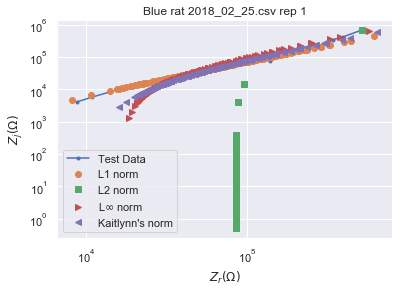

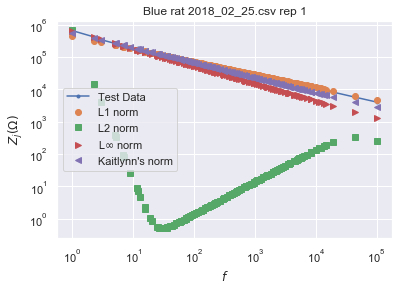

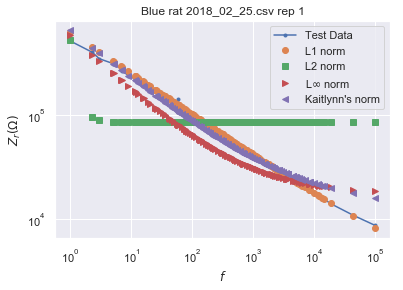

Optimization runtime 38.0401 seconds
Objective value: 26063.686586879354
Paramters: [4.33319966e-01 4.67363704e-01 4.42802439e+00 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 36.7298 seconds
Objective value: 31938.994078694206
Paramters: [4.16265445e-01 5.43346114e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 37.7103 seconds
Objective value: 143017.47385929033
Paramters: [5.00000085e-01 5.08124388e-01 1.00000001e-04 1.00000000e-04
 9.99999941e+02] 

Optimization runtime 40.3898 seconds
Objective value: 5292475756.853041
Paramters: [4.01541106e-01 5.89271158e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



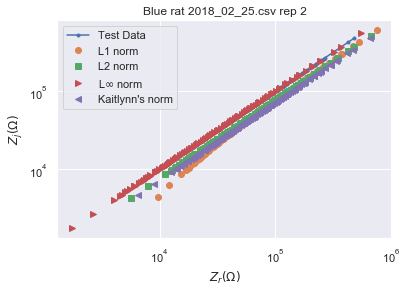

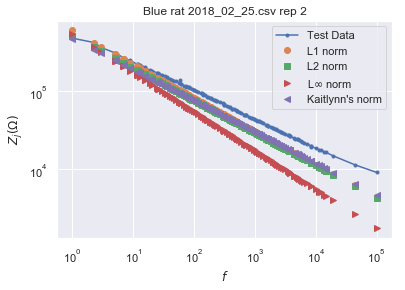

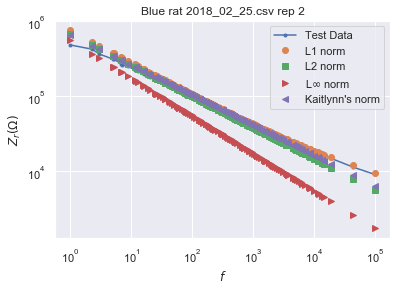

Optimization runtime 48.5198 seconds
Objective value: 126443.58642560075
Paramters: [4.38247417e+00 1.26691732e-04 6.38073642e+01 9.99795458e+02
 1.56239616e-01] 

Optimization runtime 49.9103 seconds
Objective value: 157483.43120830052
Paramters: [4.39080820e+00 1.24443203e-04 9.58745863e+01 9.27643278e+02
 1.00000000e-02] 

Optimization runtime 48.8401 seconds
Objective value: 1076305.5001388341
Paramters: [4.20261065e+00 1.98658125e-04 3.73670731e+02 3.82131911e+01
 9.66859006e+02] 

Optimization runtime 54.6501 seconds
Objective value: 758059939541.3132
Paramters: [5.27277062e-01 2.95498331e-01 3.28253848e+01 1.00000000e+03
 1.00000000e-02] 



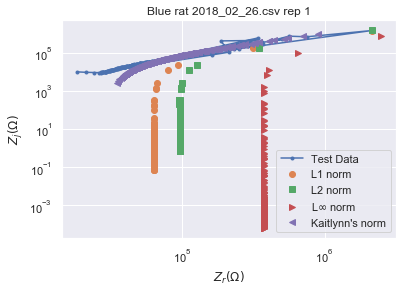

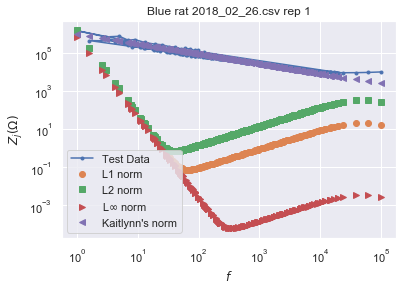

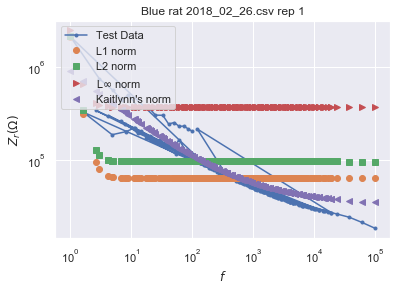

Optimization runtime 48.2598 seconds
Objective value: 65273.74740754306
Paramters: [4.78836094e-01 3.65161165e-01 1.91094572e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 49.2302 seconds
Objective value: 166508.68824531743
Paramters: [4.46141901e+00 1.00000000e-04 9.58293581e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 48.5899 seconds
Objective value: 1091070.6179759
Paramters: [4.45301983e+00 1.00000000e-04 3.74945166e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 53.7490 seconds
Objective value: 4577489134554.141
Paramters: [4.40604445e+00 1.00000000e-04 7.86190608e+01 1.00000000e+03
 1.00000000e-02] 



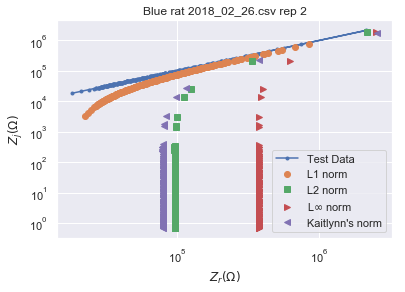

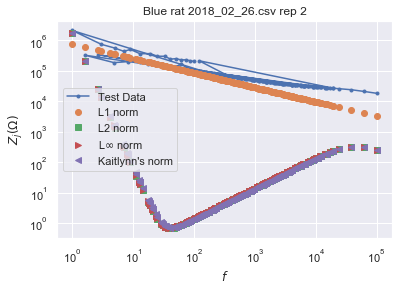

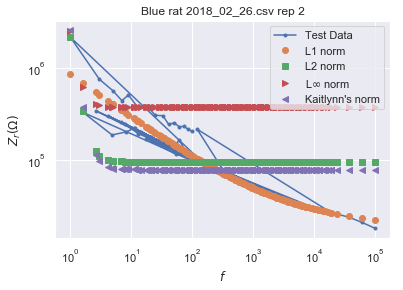

Optimization runtime 49.8101 seconds
Objective value: 1549514.3415817562
Paramters: [4.08923477e+00 1.45171096e-04 2.26449956e+02 9.72727010e+02
 1.52634121e+02] 

Optimization runtime 49.0298 seconds
Objective value: 1046899.5529502255
Paramters: [3.51792304e-01 6.72891334e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 47.5039 seconds
Objective value: 5705560.103170163
Paramters: [1.38813076e-01 1.54209724e-01 1.00000004e-04 1.00000000e-04
 9.99999829e+02] 

Optimization runtime 54.5461 seconds
Objective value: 107041658220896.66
Paramters: [3.47935395e-01 8.67342600e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



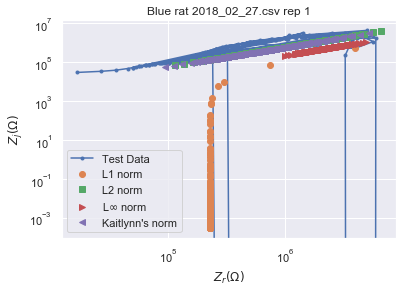

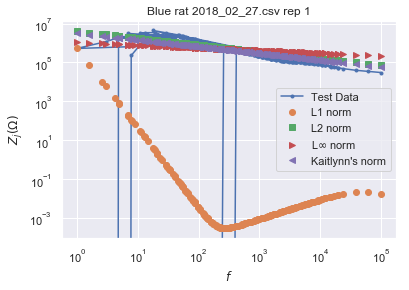

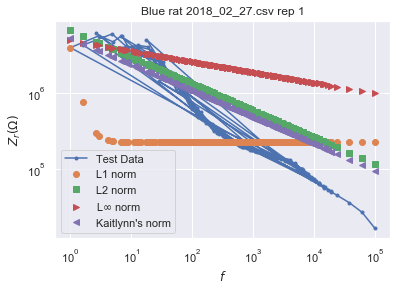

Optimization runtime 49.1601 seconds
Objective value: 1823892.2551751113
Paramters: [4.27900325e+00 1.00000000e-04 2.29804501e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 49.9398 seconds
Objective value: 2680103.065383202
Paramters: [4.26704223e+00 1.00000000e-04 9.75386031e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 51.2602 seconds
Objective value: 19308890.717432234
Paramters: [3.4394071e+00 1.0000000e-04 1.0000000e+03 1.0000000e+03 1.0000000e-02] 

Optimization runtime 54.9289 seconds
Objective value: 1462480974088876.0
Paramters: [3.36285309e+00 2.25254584e-04 3.11940975e+02 9.99758577e+02
 1.00000000e-02] 



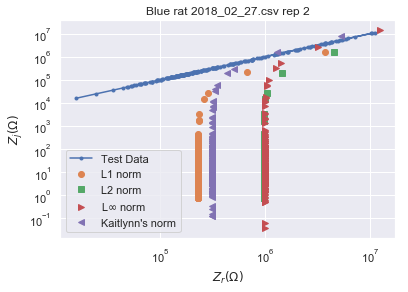

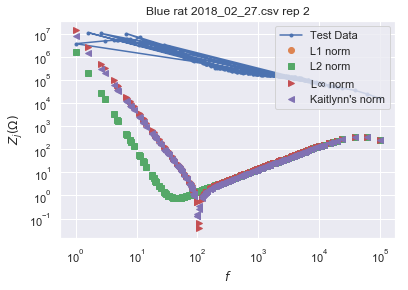

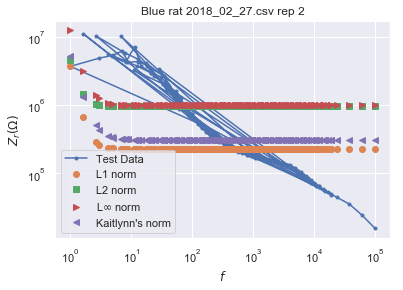

Optimization runtime 48.7041 seconds
Objective value: 1792067.7258292844
Paramters: [5.03052790e-01 5.30659275e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 48.4260 seconds
Objective value: 3141818.657417971
Paramters: [4.44088775e-01 1.52971654e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 46.5436 seconds
Objective value: 31264428.21446843
Paramters: [1.76640150e+00 2.10394377e-03 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 51.4102 seconds
Objective value: 2115045379100691.5
Paramters: [3.58608409e-01 5.87759152e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



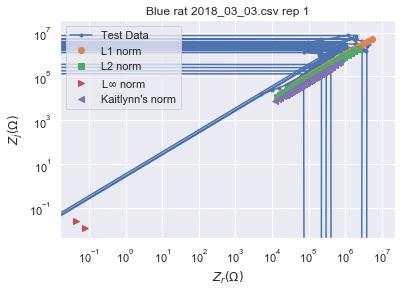

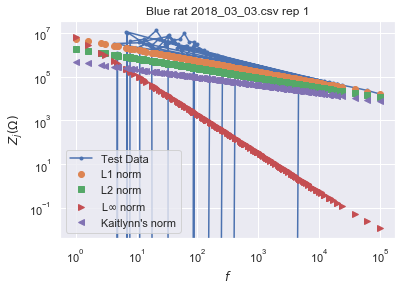

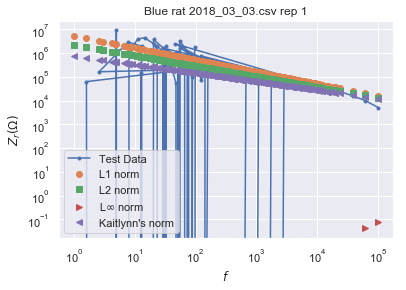

Optimization runtime 48.8702 seconds
Objective value: 1468490.8489419878
Paramters: [4.92319395e-01 5.94835144e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 47.1299 seconds
Objective value: 2779342.8266920475
Paramters: [4.22483841e-01 7.85590826e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 47.6700 seconds
Objective value: 21860566.934519608
Paramters: [6.95207058e-01 2.53808504e-02 1.02324346e-04 4.31432471e+02
 2.97833986e+02] 

Optimization runtime 51.5540 seconds
Objective value: 1741574983586727.2
Paramters: [2.57042965e-01 5.08588497e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



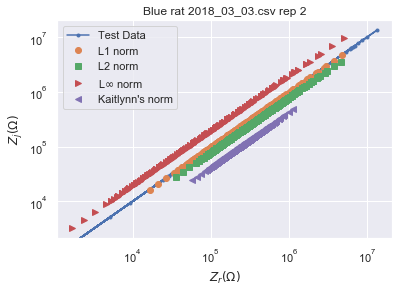

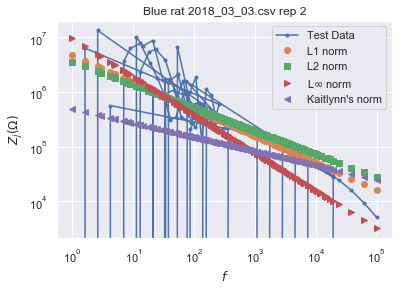

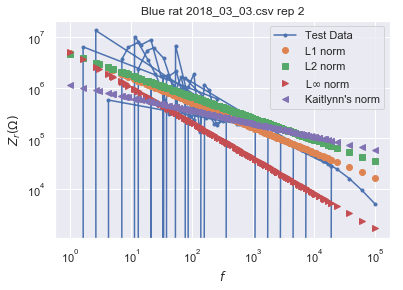

Optimization runtime 43.9341 seconds
Objective value: 55600.155813394565
Paramters: [5.60105354e-01 2.90752182e-02 4.20701868e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 44.2860 seconds
Objective value: 112972.43923244822
Paramters: [5.83387543e-01 2.38305591e-02 4.40601060e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 44.9599 seconds
Objective value: 1126131.6752331876
Paramters: [5.12963557e-01 3.11999384e-02 1.00000008e-04 6.39687232e+02
 9.99998870e+02] 

Optimization runtime 50.2000 seconds
Objective value: 144122822394.70874
Paramters: [5.41007903e-01 2.92393475e-02 1.16304453e+00 1.00000000e+03
 1.00000000e-02] 



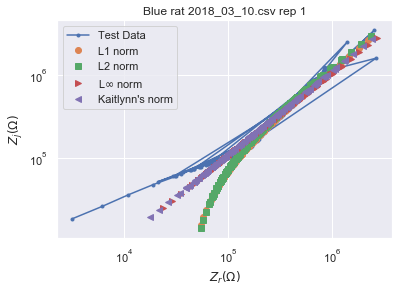

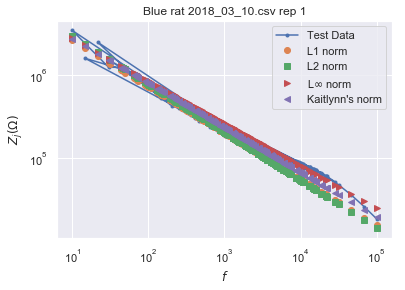

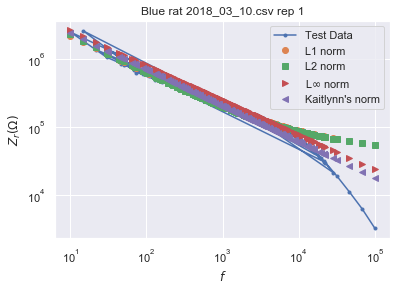

Optimization runtime 45.9100 seconds
Objective value: 64597.706870770315
Paramters: [4.99345677e-01 4.58458041e-02 1.17858976e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 46.6310 seconds
Objective value: 140861.62528395216
Paramters: [5.75149064e-01 2.57142032e-02 4.56921615e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 46.3590 seconds
Objective value: 1265145.6546737729
Paramters: [6.39205208e-01 2.10096257e-02 7.65527924e+02 5.56722929e+02
 2.03400686e+02] 

Optimization runtime 51.4006 seconds
Objective value: 314219588053.3755
Paramters: [5.57775706e-01 2.84561496e-02 1.30010197e+00 1.00000000e+03
 1.00000000e-02] 



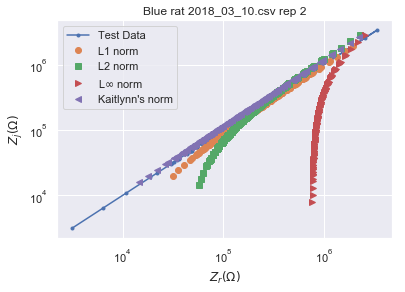

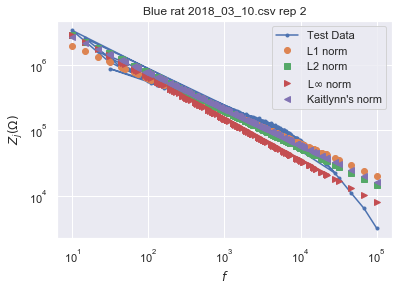

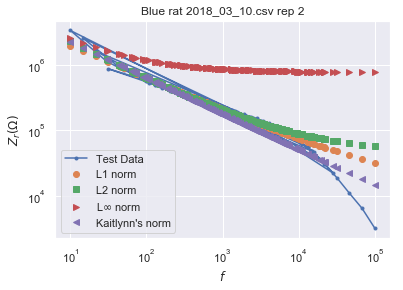

In [17]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[4, 0] = 1e-2
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_linf = np.zeros((10, 6))
res_lk = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations
        _, _, x_l1, opt_l1 = opt_routine(otto_model_L1)
        _, _, x_l2, opt_l2 = opt_routine(otto_model_L2)
        _, _, x_linf, opt_linf = opt_routine(otto_model_L_inf)
        _, _, x_lk, opt_lk = opt_routine(otto_model_L2_Kait)
        plot_results(f, x_l1, x_l2, x_linf, x_lk,
                     'Blue rat ' + data + ' rep ' + str(i+1))

        # save the results into the array
        res_l1[ind, :5] = x_l1; res_l1[ind, 5] = opt_l1
        res_l2[ind, :5] = x_l2; res_l2[ind, 5] = opt_l2
        res_linf[ind, :5] = x_linf; res_linf[ind, 5] = opt_linf
        res_lk[ind, :5] = x_lk; res_lk[ind, 5] = opt_lk


### Results with 10 optimizations for each norm above
- It does not appear that 10 optimizations was enough to find the global optimum in some data sets
- This is evident by the very poor results from some optimizations
- The L1 norm appeared to produce the best results in 8/10 rats

### Change in optimization process
- New DE runs will have a maximum of 10,000 iterations (as opposed to 1,000)
- New optimization process will start 50 different optimizations (as opposed to 10)

In [ ]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[4, 0] = 1e-2
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_linf = np.zeros((10, 6))
res_lk = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations
        _, _, x_l1, opt_l1 = opt_routine(otto_model_L1)
        _, _, x_l2, opt_l2 = opt_routine(otto_model_L2)
        _, _, x_linf, opt_linf = opt_routine(otto_model_L_inf)
        _, _, x_lk, opt_lk = opt_routine(otto_model_L2_Kait)
        plot_results(f, x_l1, x_l2, x_linf, x_lk,
                     'Blue rat ' + data + ' rep ' + str(i+1))

        # save the results into the array
        res_l1[ind, :5] = x_l1; res_l1[ind, 5] = opt_l1
        res_l2[ind, :5] = x_l2; res_l2[ind, 5] = opt_l2
        res_linf[ind, :5] = x_linf; res_linf[ind, 5] = opt_linf
        res_lk[ind, :5] = x_lk; res_lk[ind, 5] = opt_lk
